In [1]:
# Import necessary libraries
import cdflib
import xarray as xr
import os
import urllib.request
import numpy as np
import pandas as pd
import datetime as dt
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import math

import sys
import h5py
import dask
import h5netcdf
import flox
import importlib as il 
import ecef_geodetic

In [9]:
fname = ['GR_OPER_TEC1TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC1TMS_2F_20130318T000000_20130318T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130316T000000_20130316T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130317T000000_20130317T235959_0101.cdf', 'GR_OPER_TEC2TMS_2F_20130318T000000_20130318T235959_0101.cdf']
grace_data = []


# Adding the local time
ecef_geodetic = il.reload(ecef_geodetic)


for f in tqdm(fname):
    path = 'ESA_GRACE_data/' + f
    data = xr.Dataset()
    d = cdflib.CDF(path)

    step = range(len(d['Timestamp']))
    
    for var_name in d.cdf_info().zVariables:
        
        var_data = d[var_name]

        if var_name == 'DCB' or var_name == 'DCB_Error' :
            data[var_name] = d[var_name]
        
        elif type(var_data[0]) == np.ndarray:
            var_name1 = var_name + '_X'
            var_name2 = var_name + '_Y'
            var_name3 = var_name + '_Z'
            data[var_name1] = ('step', [i for i,j,k in var_data], {'step': step})
            data[var_name2] = ('step', [j for i,j,k in var_data], {'step': step})
            data[var_name3] = ('step', [k for i,j,k in var_data], {'step': step})

        else:
            data[var_name] = ('step', var_data, {'step': step})


    d0 = dt.datetime.strptime(f.split('_')[4], '%Y%m%dT%f')
    date = [d0 + pd.Timedelta(milliseconds = (i - data.Timestamp[0].values)) for i in data.Timestamp.values]
    data['date'] = ('step', [i for i in date], {'step': step})
    lt = ecef_geodetic.ut_to_lt(date, data['Longitude'].values)
    data['LT'] = ('step', lt, {'step':step})
    
    grace_data.append(data)

print()
print('Columns in Satellite Data: \n', d.cdf_info().zVariables)
print()
grace_data[0].data_vars


100%|█████████████████████████████████████████████| 6/6 [00:28<00:00,  4.67s/it]


Columns in Satellite Data: 
 ['Timestamp', 'Latitude', 'Longitude', 'Radius', 'GPS_Position', 'LEO_Position', 'PRN', 'L1', 'L2', 'P1', 'P2', 'S1_C_N0', 'S2_C_N0', 'Absolute_STEC', 'Absolute_VTEC', 'Elevation_Angle', 'Relative_STEC', 'Relative_STEC_RMS', 'DCB', 'DCB_Error']



Data variables:
    Timestamp          (step) float64 6.353e+13 6.353e+13 ... 6.353e+13
    Latitude           (step) float64 -56.91 -56.91 -56.91 ... 88.52 88.52 88.52
    Longitude          (step) float64 3.965 3.965 3.965 ... 45.42 45.42 45.42
    Radius             (step) float64 6.833e+06 6.833e+06 ... 6.806e+06
    GPS_Position_X     (step) float64 8.967e+05 9.566e+06 ... 8.504e+06 1.51e+07
    GPS_Position_Y     (step) float64 -1.838e+07 2.261e+07 ... -5.75e+06
    GPS_Position_Z     (step) float64 -1.952e+07 -1.043e+07 ... 2.072e+07
    LEO_Position_X     (step) float64 3.721e+06 3.721e+06 ... 1.237e+05
    LEO_Position_Y     (step) float64 2.579e+05 2.579e+05 ... 1.255e+05
    LEO_Position_Z     (step) float64 -5.725e+06 -5.725e+06 ... 6.804e+06
    PRN                (step) uint16 11 12 14 18 11 12 14 ... 10 13 16 23 29 30
    L1                 (step) float64 2.346e+07 2.354e+07 ... 2.134e+07
    L2                 (step) float64 2.346e+07 2.354e+07 ... 2.134e+07
    P1     

# Note
- LEO_Position given in the data are the positions of the GRACE satellite in the ECEF cartesian system (WGS84 is being used) and units are in meters
- GPS_Position given in the data are the positions of the GPS satellites
- Latitude, Longitude, and Radius represent the position of the GRACE satellite and they are in the spherical coordinates system (Geocentric or ECEF spherical system)
- Absolute VTEC is recommended to be calculated by using GPS rays of elevation angle as at least 50 degrees (in documentation).

In [6]:
import ecef_geodetic
import importlib as il

d1 = grace_data[4]
ecef_geodetic = il.reload(ecef_geodetic)

lat_gps = []
lon_gps = []
alt_gps = []

lat_leo = []
lon_leo = []
alt_leo = []

x_geod = []
y_geod = []
z_geod = []

radius_check = []

for x,y,z in tqdm(zip(d1.GPS_Position_X, d1.GPS_Position_Y, d1.GPS_Position_Z)):
    lat, lon, alt = ecef_geodetic.ecef_to_lla(x,y,z)
    lat_gps.append(lat)
    lon_gps.append(lon)
    alt_gps.append(alt)

for x,y,z in tqdm(zip(d1.LEO_Position_X, d1.LEO_Position_Y, d1.LEO_Position_Z)):
    lat, lon, alt = ecef_geodetic.cart_spher(x,y,z)
    lat_leo.append(lat)
    lon_leo.append(lon)
    alt_leo.append(alt)

for lat,lon,h in tqdm(zip(d1.Latitude, d1.Longitude, d1.Radius)):
    x, y, z = ecef_geodetic.spher_cart(lat,lon,h)
    x_geod.append(x)
    y_geod.append(y)
    z_geod.append(z)

d1['GPS_lat'] = ('step', lat_gps, {'step': step})
d1['GPS_lon'] = ('step', lon_gps, {'step': step})
d1['GPS_alt'] = ('step', alt_gps, {'step': step})
d1['LEO_lat'] = ('step', lat_leo, {'step': step})
d1['LEO_lon'] = ('step', lon_leo, {'step': step})
d1['LEO_alt'] = ('step', alt_leo, {'step': step})
d1['Geod_X'] = ('step', x_geod, {'step': step})
d1['Geod_Y'] = ('step', y_geod, {'step': step})
d1['Geod_Z'] = ('step', z_geod, {'step': step})

15380it [00:05, 2788.97it/s]
15380it [00:21, 699.24it/s]
15380it [00:04, 3500.02it/s]


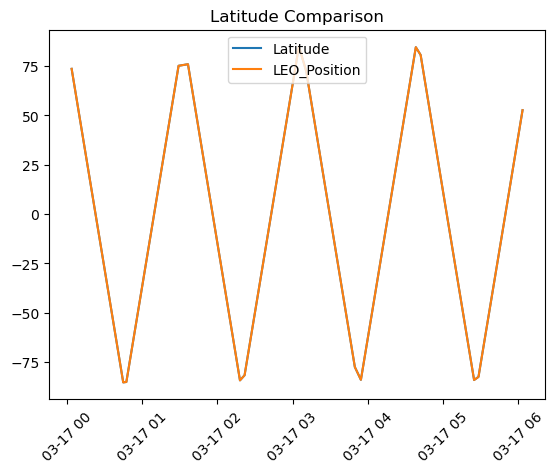

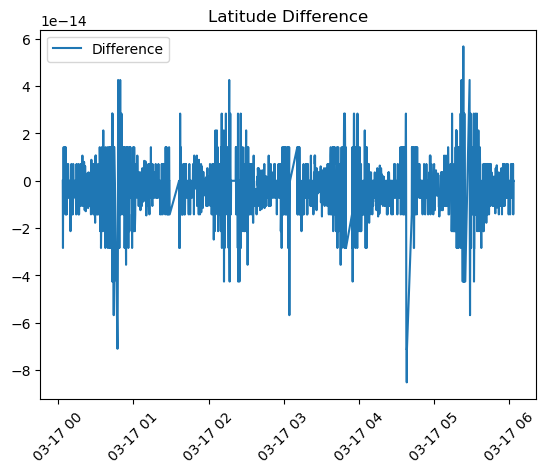

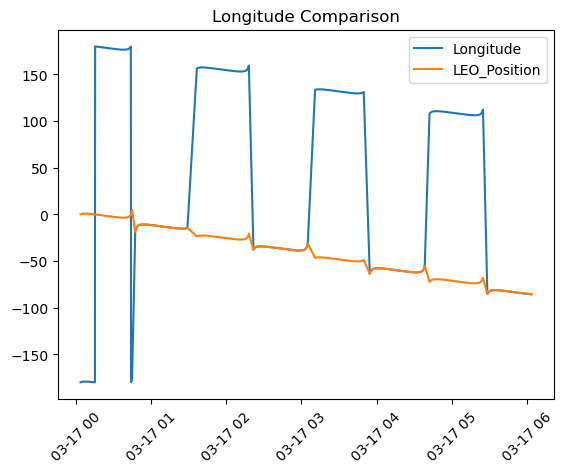

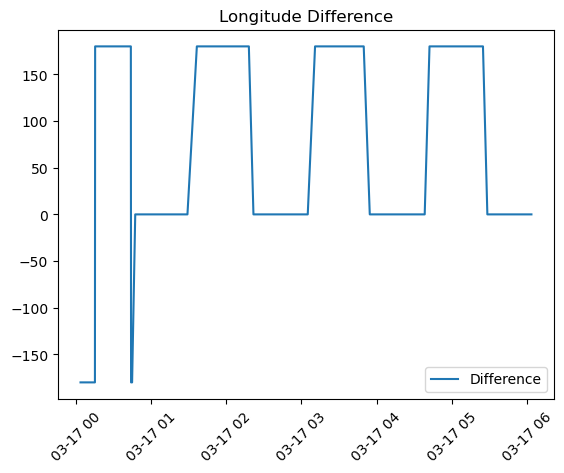

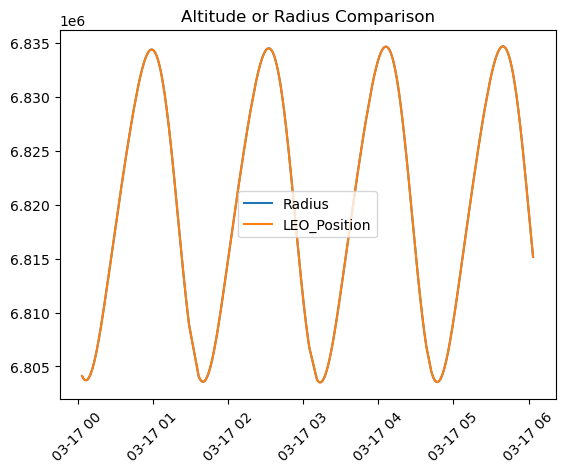

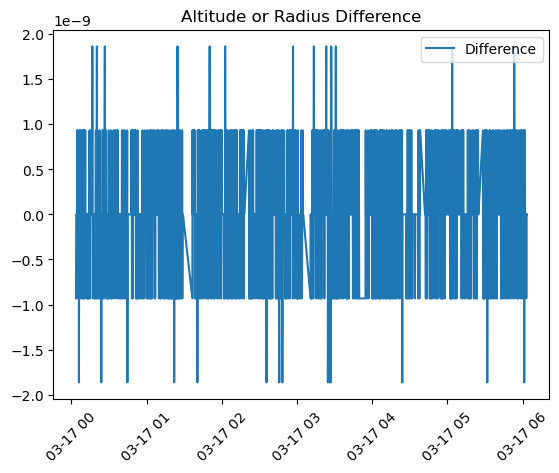

In [7]:
a = 0
b = 4000

plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_lat.values[a:b], label='LEO_Position')
plt.title('Latitude Comparison')
plt.xticks(rotation=45)

plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Latitude.values[a:b] - d1.LEO_lat.values[a:b], label='Difference')
plt.title('Latitude Difference')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Longitude.values[a:b], label='Longitude')
plt.plot(d1.date[a:b], d1.LEO_lon.values[a:b], label='LEO_Position')
plt.title('Longitude Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Longitude.values[a:b] - d1.LEO_lon.values[a:b], label='Difference')
plt.title('Longitude Difference')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b], label='Radius')
plt.plot(d1.date[a:b], d1.LEO_alt.values[a:b], label='LEO_Position')
plt.title('Altitude or Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius.values[a:b] - d1.LEO_alt.values[a:b], label='Difference')
plt.title('Altitude or Radius Difference')
plt.xticks(rotation=45)
plt.legend()
plt.show()


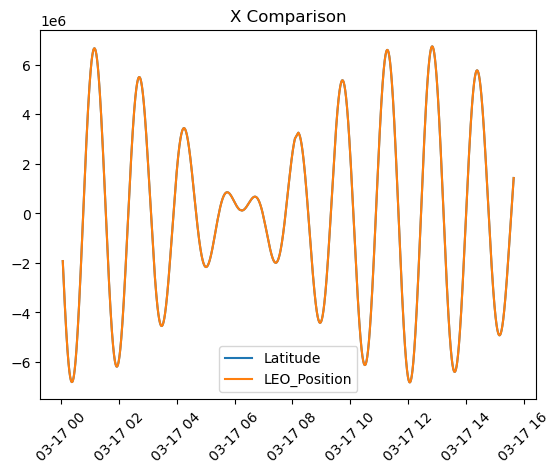

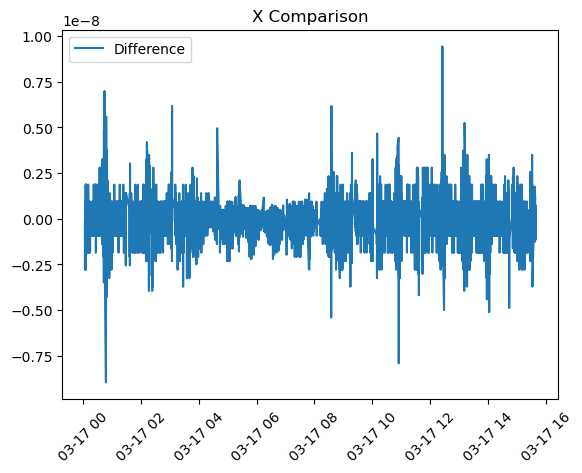

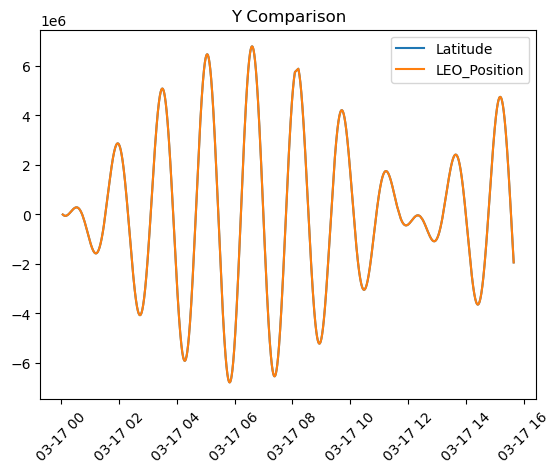

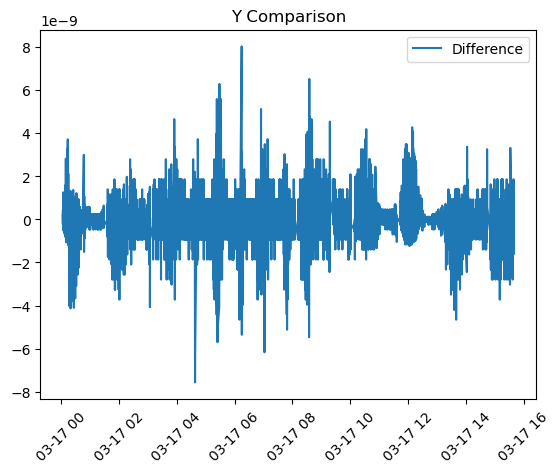

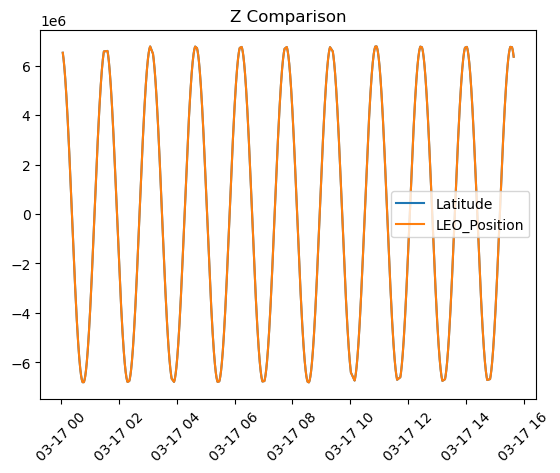

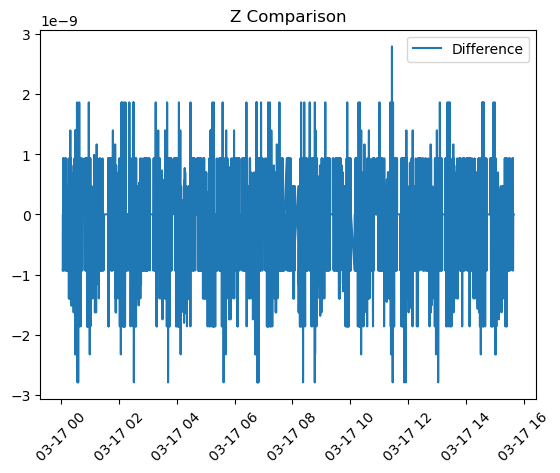

In [8]:
d1 = grace_data[4]
a = 0
b = 10000

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_X.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_X.values[a:b], label='LEO_Position')
plt.title('X Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_X.values[a:b] - d1.LEO_Position_X.values[a:b], label='Difference')
plt.title('X Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Y.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_Y.values[a:b], label='LEO_Position')
plt.title('Y Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Y.values[a:b] - d1.LEO_Position_Y.values[a:b], label='Difference')
plt.title('Y Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Z.values[a:b], label='Latitude')
plt.plot(d1.date[a:b], d1.LEO_Position_Z.values[a:b], label='LEO_Position')
plt.title('Z Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Geod_Z.values[a:b] - d1.LEO_Position_Z.values[a:b], label='Difference')
plt.title('Z Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

'''
plt.figure()
plt.plot(d1.date[a:b], d1.Radius[a:b], label='Radius Given')
plt.plot(d1.date[a:b], d1.Radius_check[a:b], label='Radius Calculated')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()

plt.figure()
plt.plot(d1.date[a:b], d1.Radius[a:b] - d1.Radius_check[a:b], label='Difference')
plt.title('Radius Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.show()
''';